Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt


def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)


Next, we shall simulate a single stock price process under the Black-Scholes dynamic, and follow the delta, stock and bond holdings over time until maturity. 

First we generate a single stock price process:

In [4]:
paths = 50000
steps = 1000
maturity = 1.0

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

r = 0.05
S0 = 100
K = 100
sigma = 0.2
dt = maturity / steps
blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

We apply this to a call option struck at 10, and today's stock price is also 10. The maturity date is 1y later, and volatility is 40%.

C:\Users\dell\AppData\Local\Temp\ipykernel_2992\4137336333.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
C:\Users\dell\AppData\Local\Temp\ipykernel_2992\4137336333.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


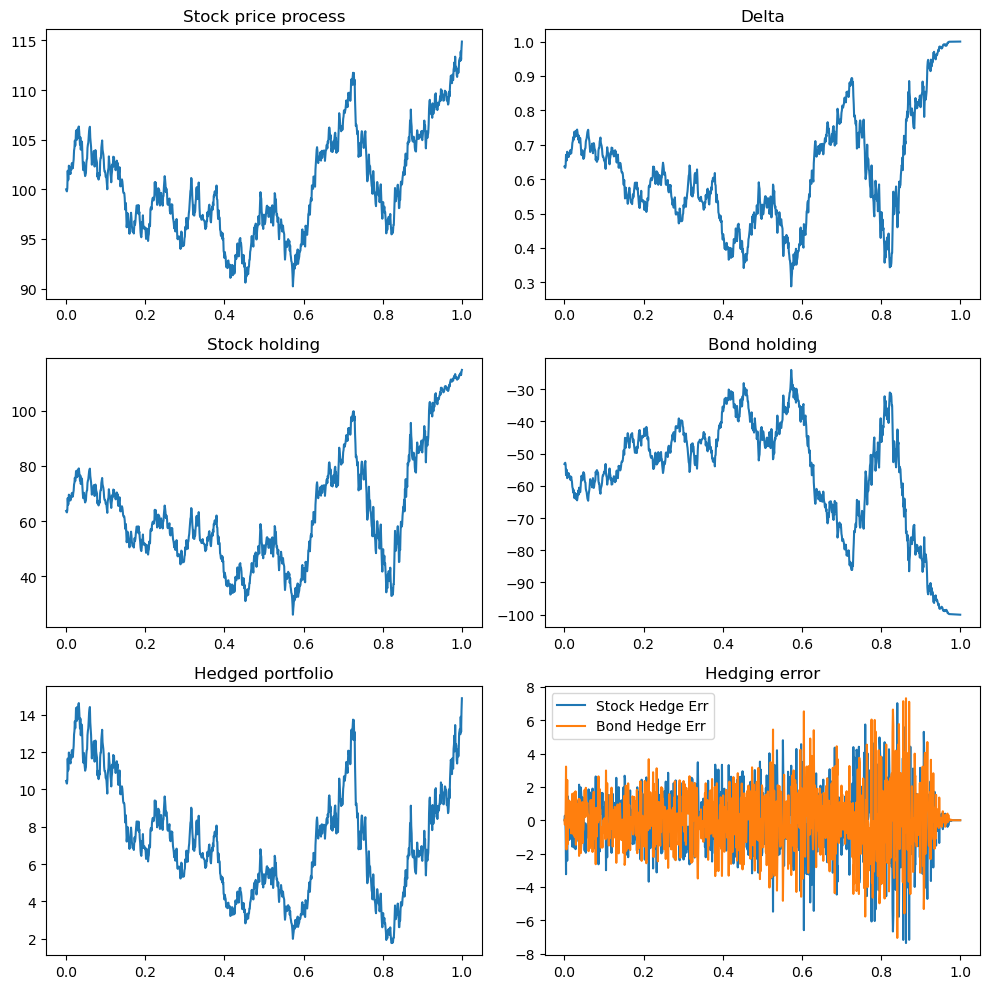

In [5]:
deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(T, blackscholespath):
    stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
    bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(phi(S_t, K, r, sigma, maturity-t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

    prev_phi = phi(S_t, K, r, sigma, maturity-t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(T, blackscholespath)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()
